In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import random
import time

In [2]:
base_dir = "./dataset2"

train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
train_class_list = os.listdir(train_dir)
train_class_list.sort(key=lambda x:int(x))
validation_class_list = os.listdir(validation_dir)
validation_class_list.sort(key=lambda x:int(x))

train_data_dir = {}
train_data_list = {}
validation_data_dir = {}
validation_data_list = {}
train_sum = 0
vali_sum = 0
for i in range(len(train_class_list)):
    train_data_dir[i] = os.path.join(train_dir, train_class_list[i])
    train_data_list[i] = os.listdir(train_data_dir[i])
    train_sum += len(train_data_list[i])
    validation_data_dir[i] = os.path.join(validation_dir, validation_class_list[i])
    validation_data_list[i] = os.listdir(validation_data_dir[i])
    vali_sum += len(validation_data_list[i])

print("train :", train_sum, "data in", len(train_class_list), "classes.")
print("validation :", vali_sum, "data in", len(validation_class_list), "classes.")
class_num = len(train_class_list)
print(train_class_list)

train : 14400 data in 4 classes.
validation : 1600 data in 4 classes.
['2', '3', '8', '9']


In [3]:
layer_node = {}
layer_node[0] = 28*28
layer_node[1] = 16
# layer_node[3] = 64
# layer_node[4] = 32
# layer_node[5] = 4
layer_node[2] = class_num
for i in range(len(layer_node)):
    if i == 0:
        print("\ninput layer\t\t", layer_node[i])
    elif i == len(layer_node)-1:
        print("output layer\t", layer_node[i])
    else:
        print("hidden layer", i, "\t", layer_node[i])

A = {}
delta = {}
W = {}
delta_W = {}
for i in range(len(layer_node) - 1):
    A[i] = np.zeros((layer_node[i + 1]), dtype=float)
    delta[i] = np.zeros((layer_node[i + 1]), dtype=float)
    # W[i] = np.ones((layer_node[i + 1], layer_node[i]), dtype=float)
    W[i] = np.random.normal(size=(layer_node[i + 1], layer_node[i]))
    delta_W[i] = np.zeros((layer_node[i + 1], layer_node[i]), dtype=float)


input layer		 784
hidden layer 1 	 16
output layer	 4


In [18]:
epochs = 3
train_batchs = 1000
validation_batchs = 800
lr = 0.5
stop_MSE = 0.001

history = np.zeros((4, epochs), dtype=float)
train_ACC = np.zeros(train_batchs, dtype=float)
train_MSE = np.zeros(train_batchs, dtype=float)
validation_ACC = np.zeros(validation_batchs, dtype=float)
validation_MSE = np.zeros(validation_batchs, dtype=float)
done = False

for epoch in range(epochs):
    time_S = time.time()
    for batch in range(train_batchs):
        class_int = random.randint(0, class_num-1)
        list_int = random.randint(0, len(train_data_list[class_int])-1)
        img_dir = os.path.join(train_dir, train_class_list[class_int], train_data_list[class_int][list_int])
        # class_int = 0
        # img_dir = "./dataset/train/0/0001.png"
        img = mpimg.imread(img_dir)
        img = img - 0.5
        img.resize((layer_node[0], 1))
        O = np.zeros(class_num, dtype=float)
        O[class_int] = 1
        # O[0] = 1
        # if epoch == epochs-1: print(O)

        """ Forward """
        for k in range(len(layer_node) - 1):
            if k == 0:
                A[k] = np.dot(W[k], img)
            else:
                A[k] = np.dot(W[k], A[k-1])
            for i in range(len(A[k])):
                A[k][i] = 1. / (1. + math.exp(-A[k][i]))

        """ACC"""
        ANS = A[len(layer_node)-2].tolist()
        maximum = max(ANS)
        ans = ANS.index(maximum)
        if class_int == ans:
            train_ACC[batch] = 1.
        else:
            train_ACC[batch] = 0.
        # print(ans)

        """ MSE """
        MSE = 0.
        for i in range(len(O)):
            MSE += pow((O[i] - A[len(layer_node)-2][i]), 2)
        MSE /= len(O)
        train_MSE[batch] = MSE
        outstr = 'epoch ' + str(epoch+1) + " {:.2f}".format((batch/train_batchs)*100) + "% : MSE = " + "{:.6f}".format(train_MSE[batch])
        print(outstr, end="\r", flush=True)
#         print("\repoch", epoch+1, "{:.2f}".format((batch/train_batchs)*100),
#               "% : MSE =", "{:.6f}".format(train_MSE[batch]), end="\r", flush=True)


        """ Delta """
        for k in range(len(layer_node)-1, 0, -1):
            if k == len(layer_node) - 1:
                for j in range(layer_node[k]):
                    delta[k - 1][j] = (O[j] - A[k - 1][j]) * A[k - 1][j] * (1 - A[k - 1][j])
            else:
                for j in range(layer_node[k]):
                    delta[k-1][j] = 0.
                    for i in range(layer_node[k+1]):
                        delta[k-1][j] += W[k][i][j] * delta[k][i]
                    delta[k-1][j] = delta[k-1][j] * A[k-1][j] * (1 - A[k-1][j])

        """Learning Rule"""
        for k in range(len(layer_node) - 1):
            for j in range(layer_node[k + 1]):
                for i in range(layer_node[k]):
                    if k == 0:
                        delta_W[k][j][i] = lr * delta[k][j] * img[i]
                    else:
                        delta_W[k][j][i] = lr * delta[k][j] * A[k-1][i]

        """Update New Weight"""
        for k in range(len(layer_node) - 1):
            for j in range(layer_node[k + 1]):
                for i in range(layer_node[k]):
                    W[k][j][i] += delta_W[k][j][i]

    """validation"""
    for batch in range(validation_batchs):
        class_int = random.randint(0, class_num - 1)
        list_int = random.randint(0, len(validation_data_list[class_int]) - 1)
        img_dir = os.path.join(validation_dir, validation_class_list[class_int],
                               validation_data_list[class_int][list_int])
        img = mpimg.imread(img_dir)
        img = img - 0.5
        img.resize((layer_node[0], 1))
        O = np.zeros(class_num, dtype=float)
        O[class_int] = 1

        """ Forward """
        for k in range(len(layer_node) - 1):
            if k == 0:
                A[k] = np.dot(W[k], img)
            else:
                A[k] = np.dot(W[k], A[k - 1])
            for i in range(len(A[k])):
                A[k][i] = 1. / (1. + math.exp(-A[k][i]))

        """ACC"""
        ANS = A[len(layer_node) - 2].tolist()
        maximum = max(ANS)
        ans = ANS.index(maximum)
        if class_int == ans:
            validation_ACC[batch] = 1.
        else:
            validation_ACC[batch] = 0.
        # print(ans)

        """ MSE """
        MSE = 0.
        for i in range(len(O)):
            MSE += pow((O[i] - A[len(layer_node) - 2][i]), 2)
        MSE /= len(O)
        validation_MSE[batch] = MSE
#         print("\repoch", epoch + 1, "validation", "{:.2f}".format((batch / validation_batchs) * 100),
#               "% : MSE =", "{:.6f}".format(validation_MSE[batch]), end="", flush=True)

    #
    time_E = time.time()
    # epoch_MSE = np.mean(batch_MSE)
    history[0][epoch] = np.mean(train_MSE)
    history[1][epoch] = np.sum(train_ACC) / train_batchs
    history[2][epoch] = np.mean(validation_MSE)
    history[3][epoch] = np.sum(validation_ACC) / validation_batchs
    # print("\repoch", epoch + 1, ": MSE =", MSE, end="")
    print("\repoch", epoch+1, ": Train_MSE =", "{:.4f}".format(history[0][epoch]),
          "Train_ACC =", "{:.2f}".format(history[1][epoch]),
          "Validation_MSE =", "{:.4f}".format(history[2][epoch]),
          "Validation_ACC =", "{:.2f}".format(history[3][epoch]),
          "Time =", "{:.0f}".format(time_E - time_S), flush=True)
    # print(batch_MSE)
    if history[2][epoch] < stop_MSE or epoch == epochs-1:
        print(O)
        print(A[len(layer_node) - 2])
        done = True
        break

epoch 1 : Train_MSE = 0.0365 Train_ACC = 0.91 Validation_MSE = 0.0301 Validation_ACC = 0.93 Time = 65
epoch 2 : Train_MSE = 0.0337 Train_ACC = 0.92 Validation_MSE = 0.0293 Validation_ACC = 0.93 Time = 64
epoch 3 : Train_MSE = 0.0371 Train_ACC = 0.91 Validation_MSE = 0.0330 Validation_ACC = 0.92 Time = 67
[0. 0. 1. 0.]
[[8.06430087e-01]
 [4.60466843e-06]
 [3.60758763e-03]
 [1.00735062e-01]]


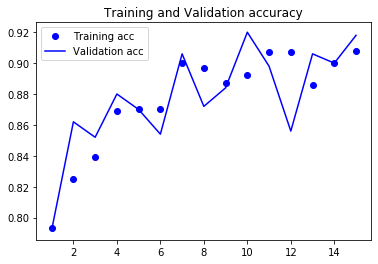

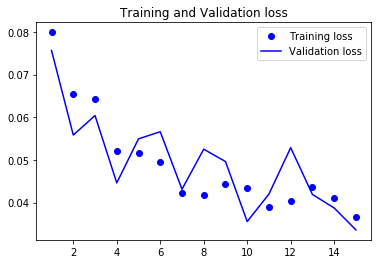

In [6]:
epochs = range(1, len(history[1]) + 1)

plt.plot(epochs, history[1], 'bo', label='Training acc')
plt.plot(epochs, history[3], 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, history[0], 'bo', label='Training loss')
plt.plot(epochs, history[2], 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [15]:
# test_dir = '../../../Billy/NTPU_Deep_Learning/HW1/test'
test_dir = '//Volumes/ADATA HD330/testing'
test_list = os.listdir(test_dir)
test_list.sort(key=lambda x:int(x[:-4]))
f = open('Answer.txt', 'w', encoding = 'UTF-8')
print(len(test_list))

for j in range(len(test_list)):
    img_dir = os.path.join(test_dir, test_list[j])
    img = mpimg.imread(img_dir)
    img = img - 0.5
    img.resize((layer_node[0], 1))
    O = np.zeros(class_num, dtype=float)
    O[class_int] = 1

    """ Forward """
    for k in range(len(layer_node) - 1):
        if k == 0:
            A[k] = np.dot(W[k], img)
        else:
            A[k] = np.dot(W[k], A[k - 1])
        for i in range(len(A[k])):
            A[k][i] = 1. / (1. + math.exp(-A[k][i]))
            
    ANS = A[len(layer_node) - 2].tolist()
#     print(ANS)
    maximum = max(ANS)
    ans = ANS.index(maximum)
    out = test_list[j][:-4] + ' ' + str(train_class_list[ans]) + '\n'
    f.write(out)

print('finish')
f.close()

4000
finish
